## Labelling Data  
To split the 'Entity' and 'Address' from the cleaned dataset into a string each and  
label the data with 0 and 1 for 'Entity' and 'Address' respectively.  
Remove the data if both 'Entity' and 'Address' are null.

In [1]:
#install transformers
!pip install transformers
!pip install --upgrade tensorflow-io
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 40.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


In [2]:
import pandas as pd
import numpy as np
import ast
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, TFDistilBertForTokenClassification, TFAutoModelForTokenClassification
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def read_data(file_path):
    data = pd.read_csv(file_path)
    #data = ori_data.loc[0:500000] 
    return data

def remove_empty_row(data):
    data = data.dropna(subset=['Entity', 'Address'], how='all')
    return data

def check_address_exist(labels):
    if labels:
        return 0
    else:
        return 1
    
def combine_columns(entity, address):
    entity_split = []
    address_split = []
    
    if pd.notnull(entity):
        entity_split = entity.split()
        
    if pd.notnull(address):
        address_split = address.split()
        
    return entity_split + address_split

def create_dataset_with_address(data):
    data_with_address = data[data['Class'] == 1]
    return data_with_address

def generate_labels(row):
    entity_str = str(row['Entity']) if pd.notnull(row['Entity']) else ''
    address_str = str(row['Address']) if pd.notnull(row['Address']) else ''
    
    entity_labels = [0] * len(entity_str.split())
    address_labels = [1] * len(address_str.split())
    return entity_labels + address_labels

In [4]:
FILE_PATH = '/kaggle/input/save-output-with-address/data_with_address_column.csv'
data = read_data(FILE_PATH)
data = remove_empty_row(data)
print(len(data))
data.loc[:, 'Class'] = data.apply(lambda x: check_address_exist(pd.isnull(x['Address'])), axis=1)
data.loc[:, 'Entity_Address'] = data.apply(lambda x: combine_columns(x['Entity'], x['Address']), axis=1)
data = create_dataset_with_address(data)
print(len(data))
print(data.head())

/tmp/ipykernel_28/3629336091.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


1749498
1749498
            Entity     Address  Class                Entity_Address
0      kelly scott      london      1        [kelly, scott, london]
1  Caroline Barlow      london      1    [Caroline, Barlow, london]
2   peter saunders     bromley      1    [peter, saunders, bromley]
3     eleanor grey      london      1       [eleanor, grey, london]
4    declan hughes  birmingham      1  [declan, hughes, birmingham]


In [5]:
data = data.reset_index(drop=True)
print(len(data))

1749498


In [6]:
data = data.loc[0:249999] 
data['Labels'] = data.apply(lambda row: generate_labels(row), axis=1)
print(data.head())

            Entity     Address  Class                Entity_Address     Labels
0      kelly scott      london      1        [kelly, scott, london]  [0, 0, 1]
1  Caroline Barlow      london      1    [Caroline, Barlow, london]  [0, 0, 1]
2   peter saunders     bromley      1    [peter, saunders, bromley]  [0, 0, 1]
3     eleanor grey      london      1       [eleanor, grey, london]  [0, 0, 1]
4    declan hughes  birmingham      1  [declan, hughes, birmingham]  [0, 0, 1]


In [7]:
print(len(data))

200000


In [8]:
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
input_ids = []
attention_masks = []

# Tokenize the 'Entity_Address' column and generate input_ids and attention_masks
for entity_address_row in data['Entity_Address']:
    tokens = tokenizer(entity_address_row, truncation=True, padding='max_length', max_length=10, return_tensors='tf')
    input_ids.extend(tokens['input_ids'])
    attention_masks.extend(tokens['attention_mask'])

# Convert the lists to numpy arrays
input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

# encoded_data = x.apply(lambda row: tokenizer(row, truncation=True, padding='max_length', max_length=300, return_tensors='tf'))
# input_ids = np.array(encoded_data.apply(lambda x: x['input_ids']).tolist())
# attention_masks = np.array(encoded_data.apply(lambda x: x['attention_mask']).tolist())


# for entity_address_row in x:
#     tokens = tokenizer(entity_address_row, truncation=True, padding=True, return_tensors='tf')
#     input_ids.extend(tokens['input_ids'])
#     attention_masks.extend(tokens['attention_mask'])

# input_ids = np.array(input_ids)
# attention_masks = np.array(attention_masks)
# print(data.head())

In [9]:
# Step 1: Flatten the labels array
# concatenated_labels = np.array([label for sublist in data['Labels'] for label in sublist])
# num_addresses = len(input_ids)
# concatenated_labels = concatenated_labels[:num_addresses]

flat_labels = [label for sublist in data['Labels'] for label in sublist]
concatenated_labels = np.array(flat_labels)

num_addresses = len(input_ids)
concatenated_labels = concatenated_labels[:num_addresses]
#concatenated_labels = concatenated_labels.reshape(-1, 1)

# max_seq_length = 500
# padded_labels = np.concatenate([concatenated_labels, np.zeros((num_addresses, max_seq_length - 1), dtype=np.int32)], axis=1)

In [10]:
# Check the shape of the arrays
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", concatenated_labels.shape)

Input IDs shape: (692845, 10)
Attention Masks shape: (692845, 10)
Labels shape: (692845,)


In [11]:
print(input_ids)
print(concatenated_labels)
print(len(concatenated_labels))

[[ 101 5163  102 ...    0    0    0]
 [ 101 3660  102 ...    0    0    0]
 [ 101 2414  102 ...    0    0    0]
 ...
 [ 101 2067 4580 ...    0    0    0]
 [ 101 1059 2015 ...    0    0    0]
 [ 101 1023 2595 ...    0    0    0]]
[0 0 1 ... 0 1 1]
692845


In [12]:
def predict_and_measure_performance(model, val_dataset, labels_val):
    # Perform prediction on the validation dataset
    predictions = model.predict(val_dataset)
    predicted_probs = predictions[0][:, 0]  # Use the first output and raw logits directly
    predicted_labels = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary labels

    roc_auc = roc_auc_score(labels_val, predicted_probs)
    f1 = f1_score(labels_val, predicted_labels)
    recall = recall_score(labels_val, predicted_labels)
    precision = precision_score(labels_val, predicted_labels)
    pred_accuracy = accuracy_score(labels_val, predicted_labels)

    # Create a confusion matrix
    confusion_matrix_data = tf.math.confusion_matrix(labels_val, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate row sums (true label counts) and column sums (predicted label counts)
    row_sums = confusion_matrix_data.numpy().sum(axis=1)
    col_sums = confusion_matrix_data.numpy().sum(axis=0)
    confusion_matrix_percentages = (confusion_matrix_data / row_sums[:, np.newaxis]) * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_percentages, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%)')
    plt.show()

    
    # Create and display ROC AUC plot
    fpr, tpr, _ = roc_curve(labels_val, predicted_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc, f1, recall, precision, pred_accuracy


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Fold 1/5
Epoch 1/4
4331/4331 [==============================] - 506s 109ms/step - loss: 0.1010 - accuracy: 0.9631 - val_loss: 0.0841 - val_accuracy: 0.9711
Epoch 2/4
4331/4331 [==============================] - 459s 105ms/step - loss: 0.0783 - accuracy: 0.9727 - val_loss: 0.0800 - val_accuracy: 0.9731
Epoch 3/4
4331/4331 [==============================] - 458s 105ms/step - loss: 0.0702 - accuracy: 0.9758 - val_loss: 0.0806 - val_accuracy: 0.9745
Epoch 4/4
4331/4331 [==============================] - 458s 105ms/step - loss: 0.0652 - accuracy: 0.9777 - val_loss: 0.0821 - val_accuracy: 0.9749


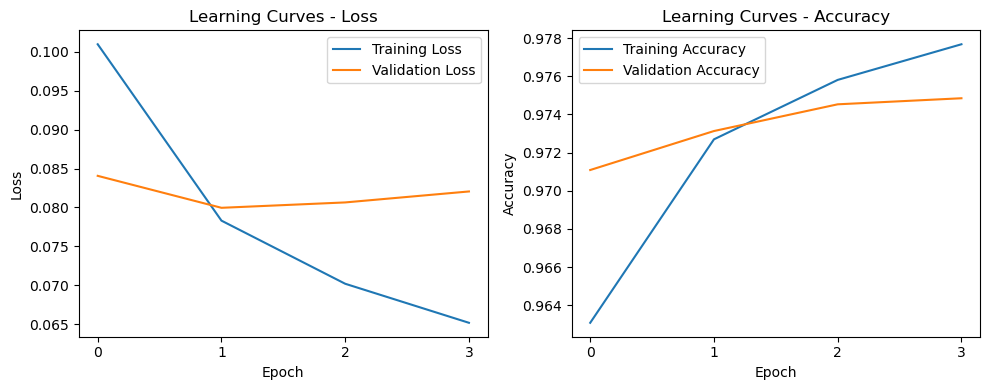

1083/1083 [==============================] - 43s 38ms/step


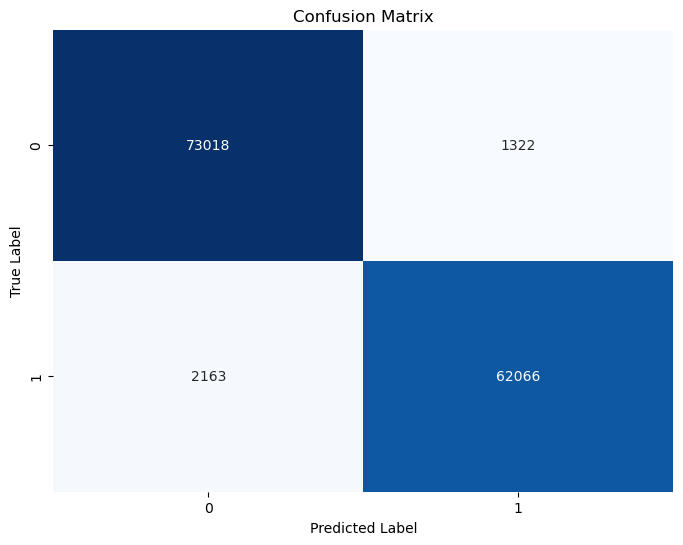

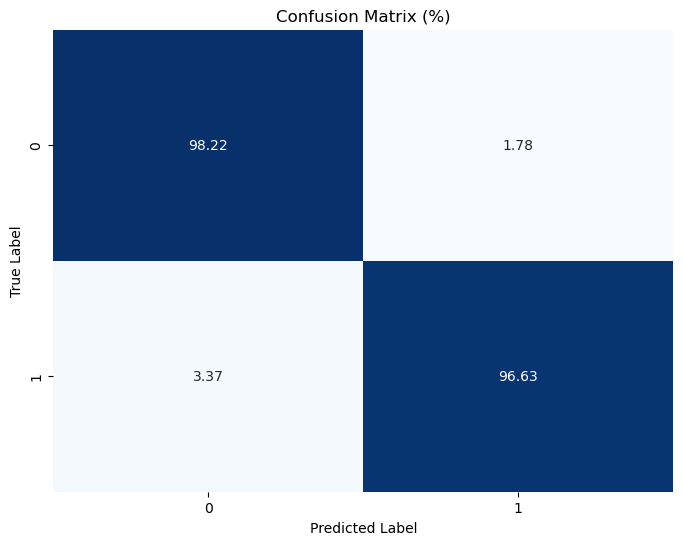

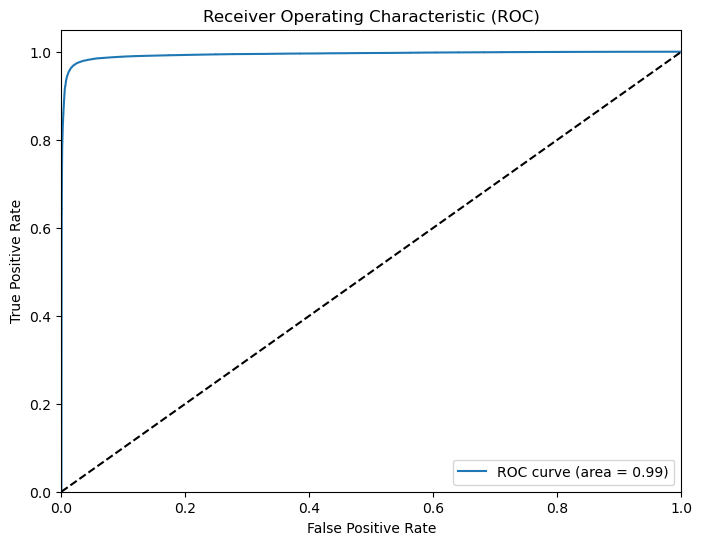

Fold 2/5
Epoch 1/4
4331/4331 [==============================] - 459s 105ms/step - loss: 0.0666 - accuracy: 0.9775 - val_loss: 0.0608 - val_accuracy: 0.9796
Epoch 2/4
4331/4331 [==============================] - 459s 106ms/step - loss: 0.0621 - accuracy: 0.9786 - val_loss: 0.0630 - val_accuracy: 0.9772
Epoch 3/4
4331/4331 [==============================] - 460s 106ms/step - loss: 0.0594 - accuracy: 0.9794 - val_loss: 0.0657 - val_accuracy: 0.9785
Epoch 4/4
4331/4331 [==============================] - 461s 106ms/step - loss: 0.0576 - accuracy: 0.9798 - val_loss: 0.0675 - val_accuracy: 0.9781


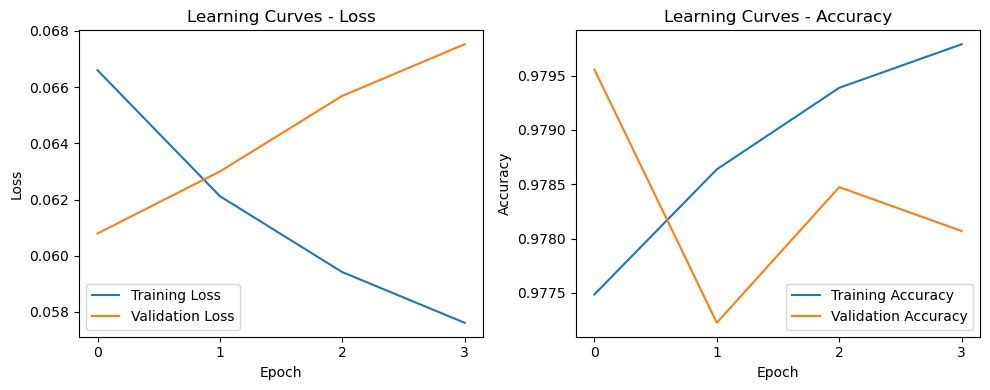

1083/1083 [==============================] - 42s 39ms/step


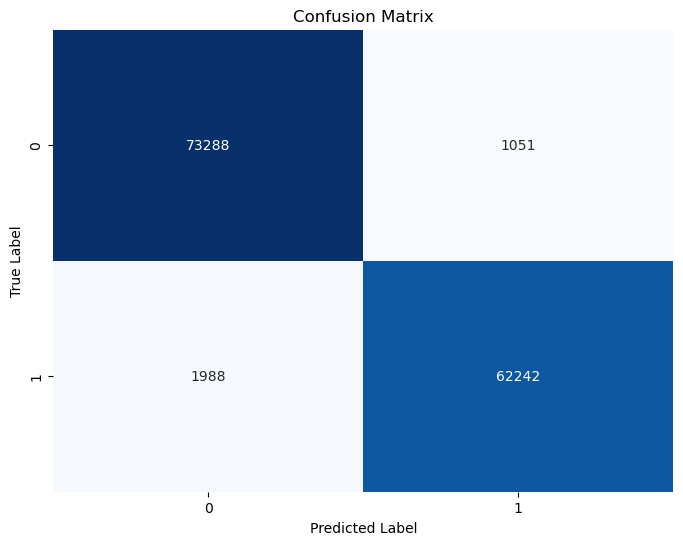

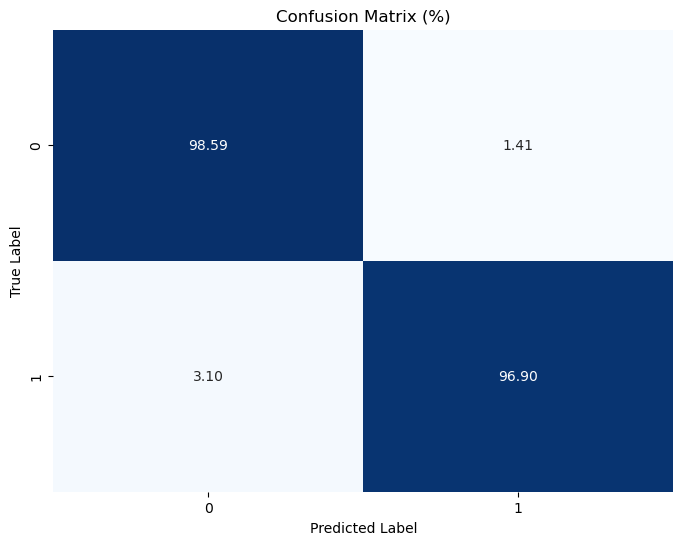

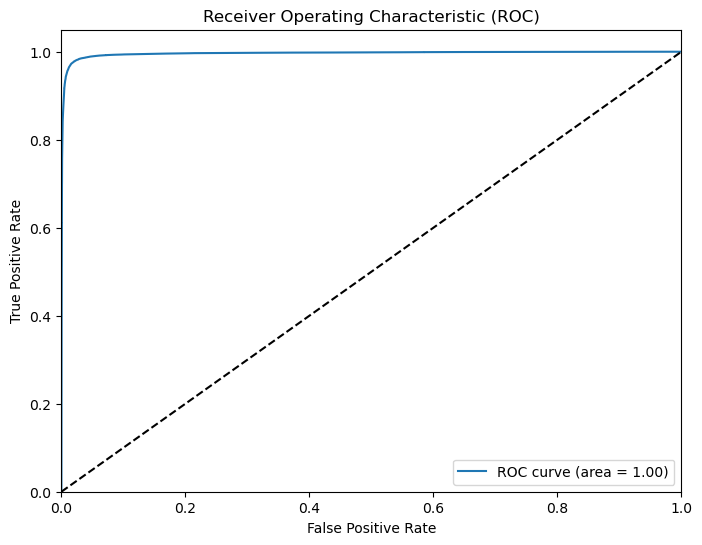

Fold 3/5
Epoch 1/4
4331/4331 [==============================] - 461s 106ms/step - loss: 0.0598 - accuracy: 0.9795 - val_loss: 0.0553 - val_accuracy: 0.9807
Epoch 2/4
4331/4331 [==============================] - 460s 106ms/step - loss: 0.0574 - accuracy: 0.9799 - val_loss: 0.0572 - val_accuracy: 0.9801
Epoch 3/4
4331/4331 [==============================] - 459s 105ms/step - loss: 0.0561 - accuracy: 0.9802 - val_loss: 0.0606 - val_accuracy: 0.9793
Epoch 4/4
4331/4331 [==============================] - 459s 105ms/step - loss: 0.0550 - accuracy: 0.9806 - val_loss: 0.0619 - val_accuracy: 0.9792


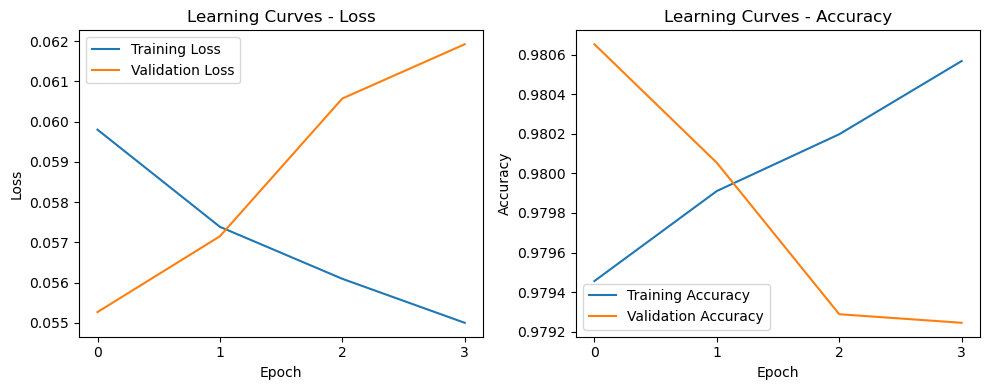

1083/1083 [==============================] - 42s 38ms/step


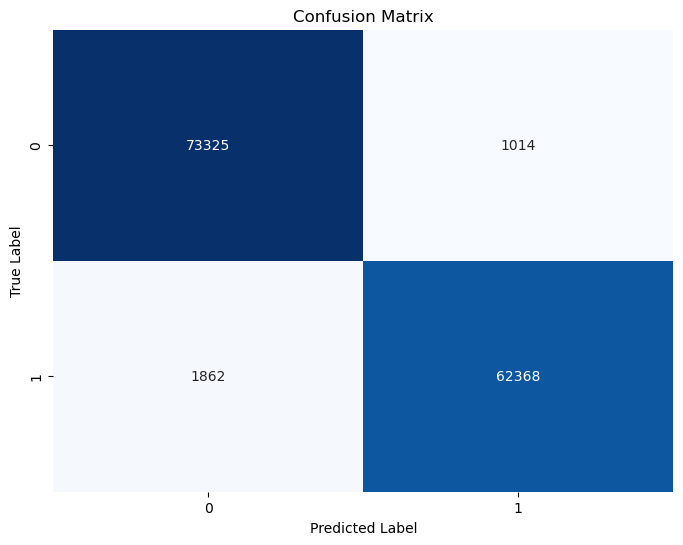

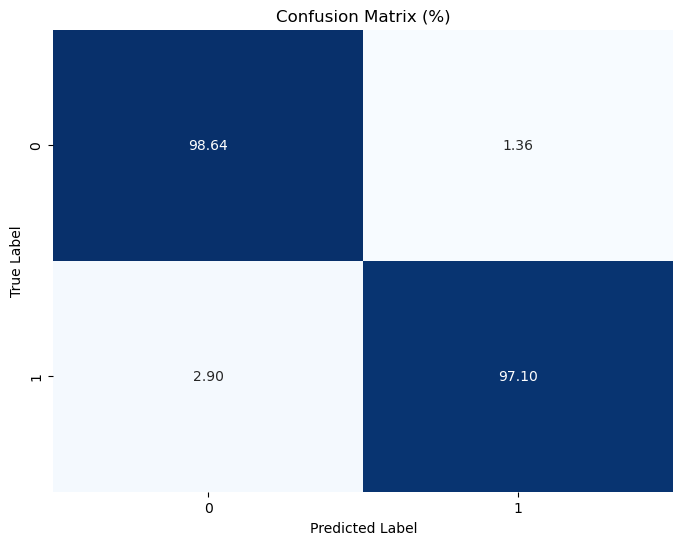

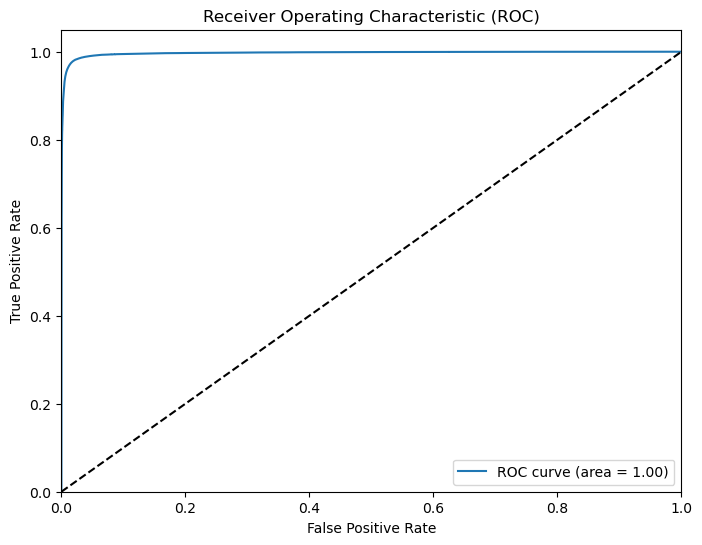

Fold 4/5
Epoch 1/4
4331/4331 [==============================] - 459s 105ms/step - loss: 0.0571 - accuracy: 0.9801 - val_loss: 0.0526 - val_accuracy: 0.9807
Epoch 2/4
4331/4331 [==============================] - 458s 105ms/step - loss: 0.0556 - accuracy: 0.9804 - val_loss: 0.0544 - val_accuracy: 0.9811
Epoch 3/4
4331/4331 [==============================] - 457s 105ms/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.0564 - val_accuracy: 0.9807
Epoch 4/4
4331/4331 [==============================] - 459s 105ms/step - loss: 0.0541 - accuracy: 0.9807 - val_loss: 0.0589 - val_accuracy: 0.9801


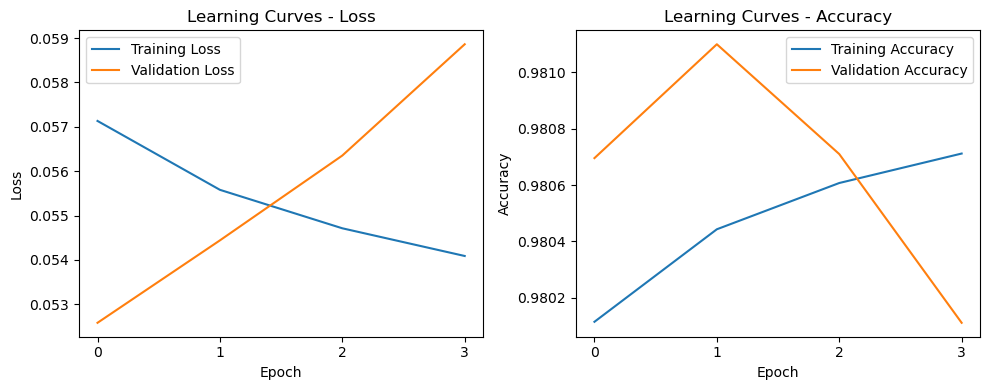

1083/1083 [==============================] - 41s 38ms/step


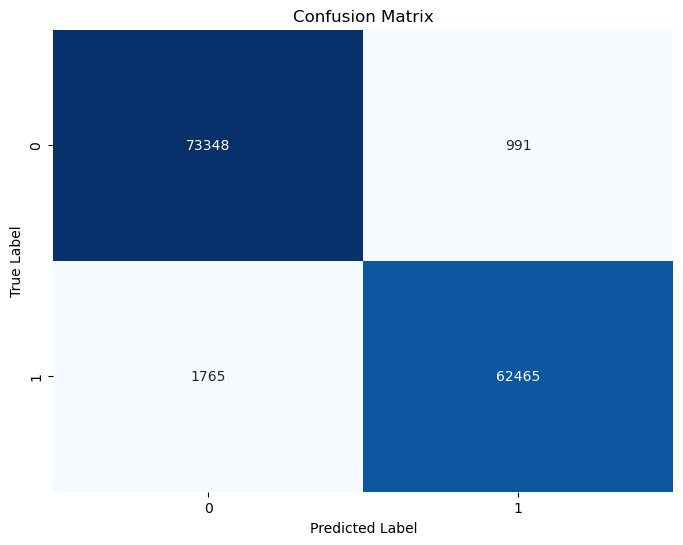

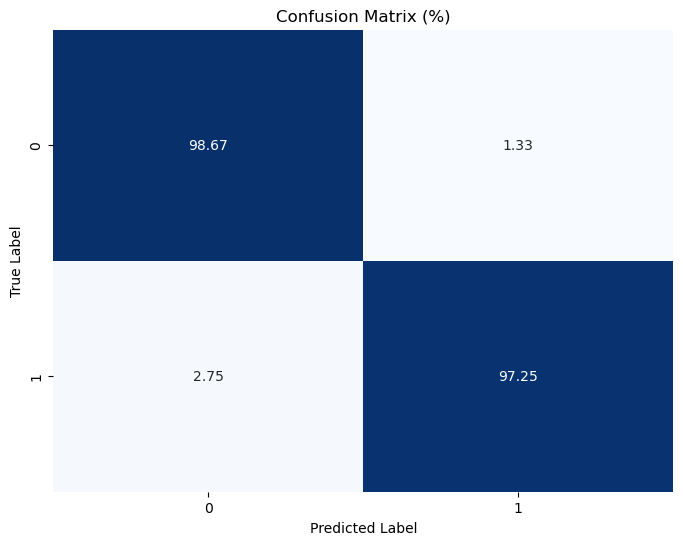

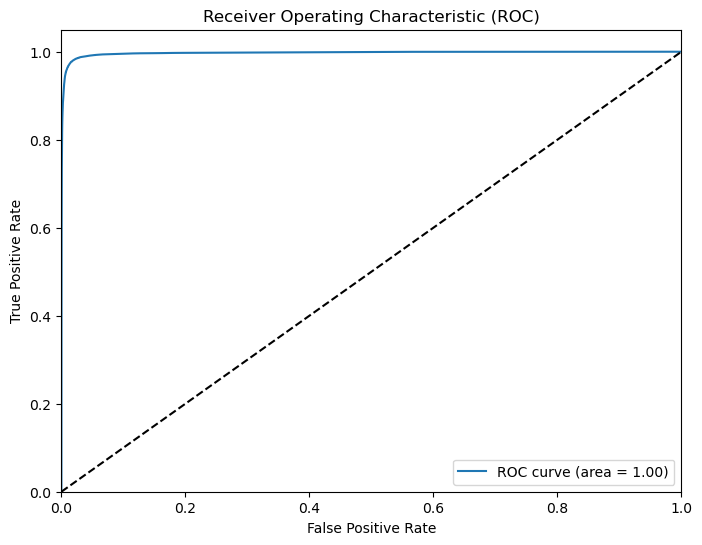

Fold 5/5
Epoch 1/4
4331/4331 [==============================] - 458s 105ms/step - loss: 0.0554 - accuracy: 0.9804 - val_loss: 0.0529 - val_accuracy: 0.9816
Epoch 2/4
4331/4331 [==============================] - 458s 105ms/step - loss: 0.0540 - accuracy: 0.9807 - val_loss: 0.0556 - val_accuracy: 0.9814
Epoch 3/4
4331/4331 [==============================] - 460s 106ms/step - loss: 0.0534 - accuracy: 0.9808 - val_loss: 0.0576 - val_accuracy: 0.9807
Epoch 4/4
4331/4331 [==============================] - 459s 106ms/step - loss: 0.0530 - accuracy: 0.9808 - val_loss: 0.0596 - val_accuracy: 0.9806


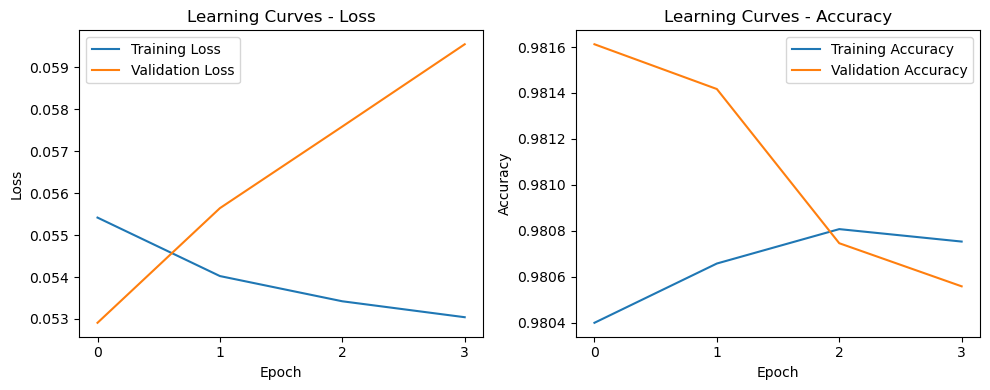

1083/1083 [==============================] - 42s 39ms/step


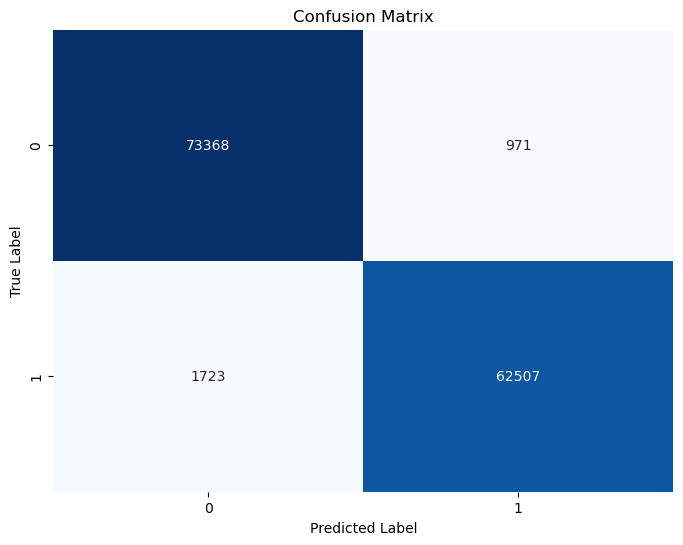

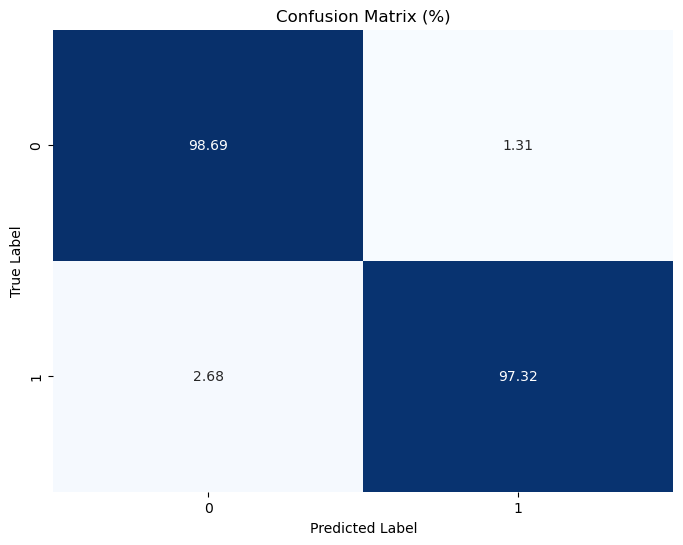

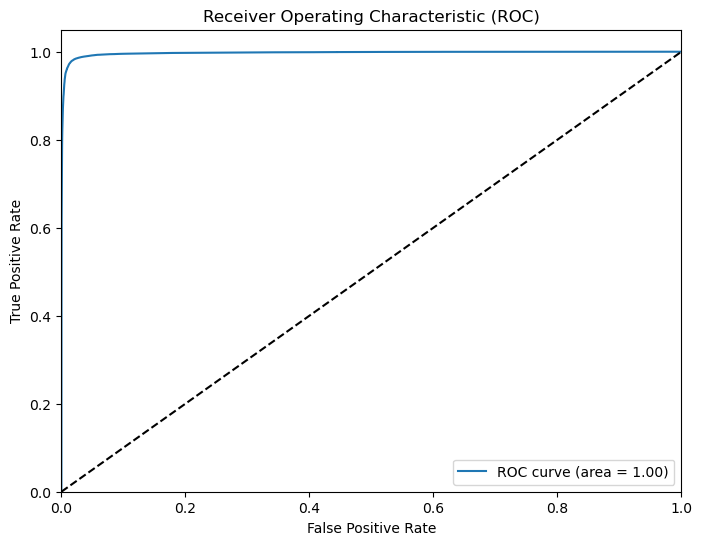

In [13]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)

# Combine input_ids, attention_masks, and labels into a single array
input_data = np.array(list(zip(input_ids, attention_masks, concatenated_labels)))

# Define the number of folds for cross-validation
num_folds = 5
num_epochs = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=46)
batch_size = 128

# Initialize a list to store validation accuracies for each fold
training_accuracies = []
training_losses = []
val_accuracies = []
val_losses = []
roc_auc_values = []
f1_values = []
recall_values = []
precision_values = []
pred_accuracies = []

# Define the loss function and optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(input_data, concatenated_labels)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into train and validation sets for this fold
    input_train_fold, input_test_fold = input_data[train_index], input_data[test_index]
    input_ids_train_fold, attention_masks_train_fold, labels_train_fold = zip(*input_train_fold)
    input_ids_test_fold, attention_masks_test_fold, labels_test_fold = zip(*input_test_fold)

    # Convert the input data and labels to numpy arrays
    input_ids_train_fold = np.array(input_ids_train_fold)
    attention_masks_train_fold = np.array(attention_masks_train_fold)
    labels_train_fold = np.array(labels_train_fold)
    
    input_ids_test_fold = np.array(input_ids_test_fold)
    attention_masks_test_fold = np.array(attention_masks_test_fold)
    labels_test_fold = np.array(labels_test_fold)

    # Convert the input data and labels to TensorFlow Dataset
    train_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_train_fold, attention_masks_train_fold))
    train_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_train_fold)
    train_dataset_fold = tf.data.Dataset.zip((train_input_dataset_fold, train_label_dataset_fold))

    test_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_test_fold, attention_masks_test_fold))
    test_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_test_fold)
    test_dataset_fold = tf.data.Dataset.zip((test_input_dataset_fold, test_label_dataset_fold))

    # Shuffle the training dataset
    train_dataset_fold = train_dataset_fold.shuffle(buffer_size=len(input_ids_train_fold))

    # Batch and prefetch the datasets separately
    train_dataset_fold = train_dataset_fold.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_fold = test_dataset_fold.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    # Train the model for this fold
    history = model.fit(train_dataset_fold, validation_data=test_dataset_fold, epochs=num_epochs)

    # Plot learning curves for this fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves - Loss')
    plt.xticks(range(0, num_epochs))
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.xticks(range(0, num_epochs))
    plt.show()
    
    training_accuracies.append(history.history['accuracy'])
    training_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])
    
    # Call the function to predict and measure performance for this fold
    (roc_auc_fold, f1_fold, recall_fold, precision_fold, pred_accuracy_fold) = predict_and_measure_performance(model, test_dataset_fold, labels_test_fold)
    
    roc_auc_values.append(roc_auc_fold)
    f1_values.append(f1_fold)
    recall_values.append(recall_fold)
    precision_values.append(precision_fold)
    pred_accuracies.append(pred_accuracy_fold)

In [14]:
print(pred_accuracies)

[0.9748500746920307, 0.9780686878017449, 0.9792449970772684, 0.9801109916359358, 0.9805584221579141]


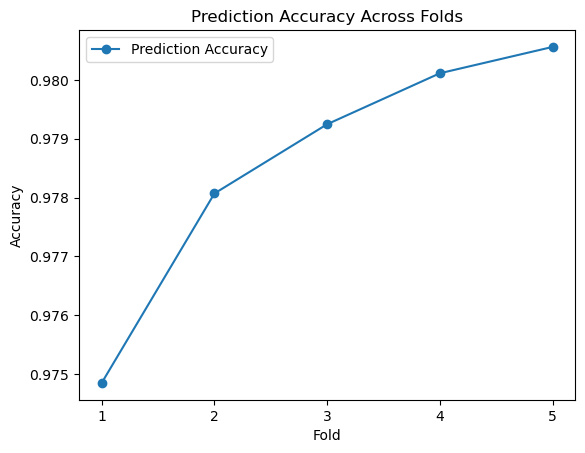

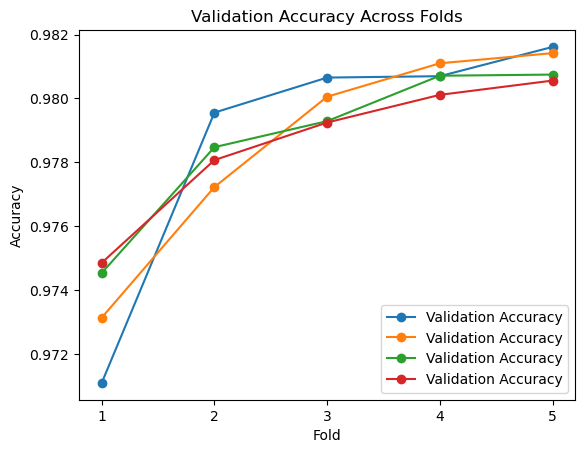

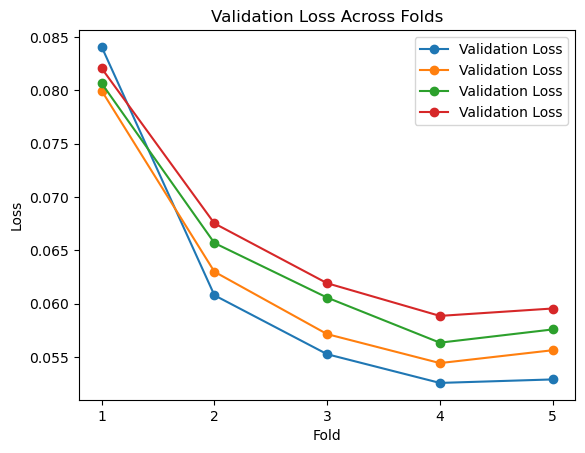

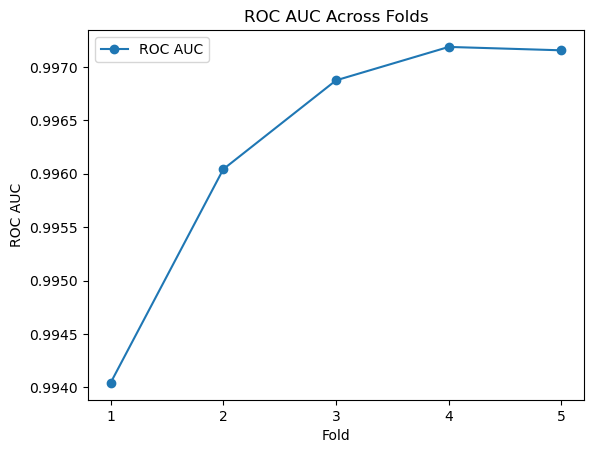

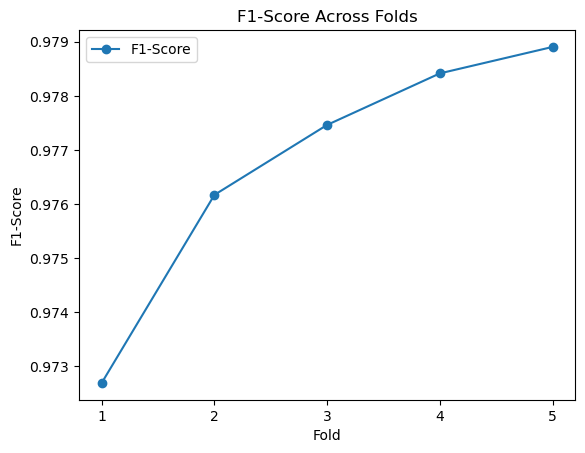

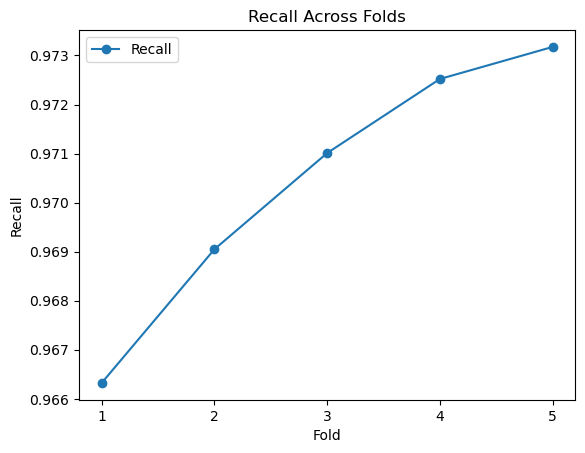

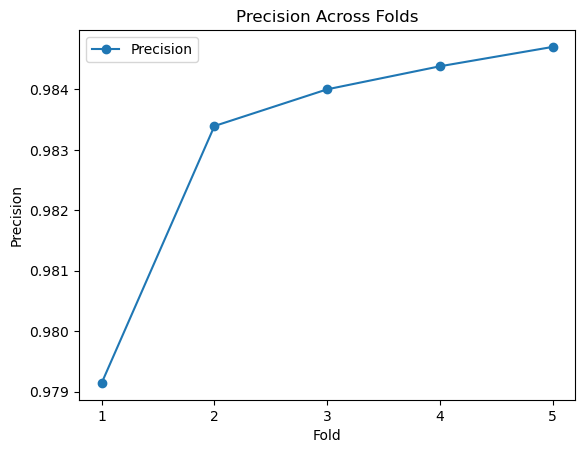

In [15]:
# Plot validation accuracy across folds
plt.plot(pred_accuracies, marker='o', label='Prediction Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy Across Folds')
plt.legend()
num = len(pred_accuracies)
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot validation accuracy across folds
plt.plot(val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot validation loss across folds
plt.plot(val_losses, marker='o', label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Validation Loss Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot ROC AUC across folds
plt.plot(roc_auc_values, marker='o', label='ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot F1-score across folds
plt.plot(f1_values, marker='o', label='F1-Score')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot recall across folds
plt.plot(recall_values, marker='o', label='Recall')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.title('Recall Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot precision across folds
plt.plot(precision_values, marker='o', label='Precision')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.title('Precision Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()


In [16]:
# Calculate the average validation accuracy, ROC AUC, F1 score, recall, and precision across all folds
#average_val_accuracy = sum(val_accuracies) / num_folds
#average_val_loss = sum(val_losses) / num_folds
average_roc_auc = sum(roc_auc_values) / num_folds
average_f1 = sum(f1_values) / num_folds
average_recall = sum(recall_values) / num_folds
average_precision = sum(precision_values) / num_folds
average_pred_accuracy = sum(pred_accuracies) / num_folds
#average_training_accuracy = sum(training_accuracies) / num_folds
#average_training_loss = sum(training_losses) / num_folds

#print(f"Average Training Accuracy: {average_training_accuracy}")
#print(f"Average Training Loss: {average_training_loss}")
#print(f"Average Validation Accuracy: {average_val_accuracy}")
#print(f"Average Validation Loss: {average_val_loss}")
print(f"Average ROC AUC: {average_roc_auc}")
print(f"Average F1 Score: {average_f1}")
print(f"Average Recall: {average_recall}")
print(f"Average Precision: {average_precision}")
print(f"Average Prediction Accuracy: {average_pred_accuracy}")

Average ROC AUC: 0.9962605090484355
Average F1 Score: 0.9767288937299139
Average Recall: 0.9704155887392909
Average Precision: 0.9831254028131987
Average Prediction Accuracy: 0.9785666346729787


In [17]:
import os
# Path to the CSV file
csv_file_path = '/kaggle/working/parameter_metrics_results_250k_max.csv'

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # Load the existing CSV file into a DataFrame
    existing_df = pd.read_csv(csv_file_path)
else:
    # Create a new DataFrame if the CSV file doesn't exist
    existing_df = pd.DataFrame()

# Create a new row with the metrics data
new_row = {'Training Accuracy': training_accuracies, 'Training Loss': training_losses,'Accuracy': val_accuracies, 'Loss': val_losses, 'ROC AUC': roc_auc_values, 'F1': f1_values, 'Recall': recall_values, 'Precision': precision_values}

# Append the new row to the existing DataFrame
existing_df = existing_df.append(new_row, ignore_index=True)

# Save the updated DataFrame back to the CSV file
existing_df.to_csv(csv_file_path, index=False)

/tmp/ipykernel_28/2447038955.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  existing_df = existing_df.append(new_row, ignore_index=True)


In [18]:
import os
# Path to the CSV file
csv_file_path = '/kaggle/working/avg_parameter_metrics_results_250k_max.csv'

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # Load the existing CSV file into a DataFrame
    existing_df = pd.read_csv(csv_file_path)
else:
    # Create a new DataFrame if the CSV file doesn't exist
    existing_df = pd.DataFrame()

# Create a new row with the metrics data
new_row = {'Accuracy': average_pred_accuracy, 'ROC AUC': average_roc_auc, 'F1': average_f1, 'Recall': average_recall, 'Precision': average_precision}

# Append the new row to the existing DataFrame
existing_df = existing_df.append(new_row, ignore_index=True)

# Save the updated DataFrame back to the CSV file
existing_df.to_csv(csv_file_path, index=False)

/tmp/ipykernel_28/2018087483.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  existing_df = existing_df.append(new_row, ignore_index=True)


In [19]:
# Input text to test
input_text = "GBG Heather Smith Plc LA1 5EB Lidl"

# Split the input text into words
words = input_text.split()

# Initialize a list to store the predicted labels for each word
predicted_labels = []

# Iterate through each word in the input text
for word in words:
    # Tokenize the word
    input_tokens = tokenizer(word, truncation=True, padding='max_length', max_length=10, return_tensors='tf')

    # Extract input IDs and attention masks from the tokenized word
    input_ids = input_tokens['input_ids']
    attention_mask = input_tokens['attention_mask']

    # Make predictions using the trained model
    predictions = model.predict([input_ids, attention_mask])

    # Interpret the model's output for the word
    predicted_prob = predictions[0][0][0]  # Probability for the "Address" class
    if predicted_prob >= 0.5:
        predicted_label = "Address"
    else:
        predicted_label = "Entity"

    predicted_labels.append((word, predicted_label))

print("Input Text:", input_text)
print("Predicted Labels for each word:", predicted_labels)


1/1 [==============================] - 0s 37ms/step
Input Text: GBG Heather Smith Plc LA1 5EB Lidl
Predicted Labels for each word: [('GBG', 'Entity'), ('Heather', 'Entity'), ('Smith', 'Entity'), ('Plc', 'Entity'), ('LA1', 'Address'), ('5EB', 'Address'), ('Lidl', 'Entity')]


In [20]:
# # Input text to test
# input_text = "Queenborough Dundee James Atkinson 3ST London"

# # Split the input text into words
# words = input_text.split()

# # Initialize a list to store the predicted labels for each word
# predicted_labels = []

# # Iterate through each word in the input text
# for word in words:
#     # Tokenize the word
#     input_tokens = tokenizer(word, truncation=True, padding='max_length', max_length=10, return_tensors='tf')

#     # Extract input IDs and attention masks from the tokenized word
#     input_ids = input_tokens['input_ids']
#     attention_mask = input_tokens['attention_mask']

#     # Make predictions using the trained model
#     predictions = model.predict([input_ids, attention_mask])

#     # Interpret the model's output for the word
#     predicted_label_index = np.argmax(predictions[0][0])
#     if predicted_label_index == 0:
#         predicted_label = "Entity"
#     else:
#         predicted_label = "Address"

#     predicted_labels.append((word, predicted_label))

# print("Input Text:", input_text)
# print("Predicted Labels for each word:", predicted_labels)


In [21]:
# # Perform prediction on the validation dataset
# predictions = model.predict(val_dataset_fold)
# predicted_probs = tf.nn.softmax(predictions.logits, axis=1).numpy()
# predicted_labels = np.argmax(predicted_probs, axis=1)
    
# # Calculate the ROC AUC
# roc_auc = roc_auc_score(labels_val_fold, predicted_probs[:, 1])

# # Calculate F1 score, recall, and precision
# f1 = f1_score(labels_val_fold, predicted_labels)
# recall = recall_score(labels_val_fold, predicted_labels)
# precision = precision_score(labels_val_fold, predicted_labels)

# # Create a confusion matrix
# confusion_matrix_data = tf.math.confusion_matrix(labels_val_fold, predicted_labels)
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [22]:
# print(roc_auc)
# print(f1)
# print(recall)
# print(precision)

In [23]:
# # Split the data using train_test_split
# input_ids_train, input_ids_val, attention_masks_train, attention_masks_val, labels_train, labels_val = train_test_split(
#     input_ids, attention_masks, concatenated_labels, test_size=0.2, random_state=42
# )

# # Convert the input data and labels to TensorFlow Dataset
# train_input_dataset = tf.data.Dataset.from_tensor_slices((input_ids_train, attention_masks_train))
# train_label_dataset = tf.data.Dataset.from_tensor_slices(labels_train)
# train_dataset = tf.data.Dataset.zip((train_input_dataset, train_label_dataset))

# val_input_dataset = tf.data.Dataset.from_tensor_slices((input_ids_val, attention_masks_val))
# val_label_dataset = tf.data.Dataset.from_tensor_slices(labels_val)
# val_dataset = tf.data.Dataset.zip((val_input_dataset, val_label_dataset))

# # Shuffle the training dataset
# train_dataset = train_dataset.shuffle(buffer_size=len(input_ids_train))

# # Batch and prefetch the datasets separately
# batch_size = 16
# train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# # Define the loss function and optimizer
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # Compile the model
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# # Train the model
# num_epochs = 3
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

In [24]:
# # After training is complete, perform evaluation on the validation dataset
# val_loss, val_accuracy = model.evaluate(val_dataset)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")

In [25]:
# def data_generator(input_ids, attention_masks, labels, batch_size):
#     num_samples = len(input_ids)
#     while True:
#         indices = tf.range(num_samples)
#         shuffled_indices = tf.random.shuffle(indices)
#         for i in range(0, num_samples, batch_size):
#             batch_indices = shuffled_indices[i:i + batch_size]
#             yield (
#                 (input_ids[batch_indices], attention_masks[batch_indices]),
#                 labels[batch_indices]
#             )

# # Split the data using train_test_split
# input_ids_train, input_ids_val, attention_masks_train, attention_masks_val, labels_train, labels_val = train_test_split(
#     input_ids, attention_masks, concatenated_labels, test_size=0.2, random_state=42
# )
# # Create custom data generators for training and validation
# batch_size = 16
# train_data_generator = data_generator(input_ids_train, attention_masks_train, labels_train, batch_size)
# val_data_generator = data_generator(input_ids_val, attention_masks_val, labels_val, batch_size)

# # Calculate the steps per epoch for training and validation
# steps_per_epoch = len(input_ids_train) // batch_size
# validation_steps = (len(input_ids_val) + batch_size - 1) // batch_size  # Calculate to cover the whole validation dataset

# # Define the loss function and optimizer
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # Compile the model (assuming your model is already defined)
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# # Train the model using the custom data generators
# num_epochs = 3
# history = model.fit(train_data_generator, steps_per_epoch=steps_per_epoch,
#                     validation_data=val_data_generator, validation_steps=validation_steps,
#                     epochs=num_epochs)

In [26]:
# # Convert the input data and labels to TensorFlow Dataset
# input_dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, concatenated_labels))
# dataset = input_dataset.shuffle(buffer_size=len(input_ids)).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# # Define the number of folds for cross-validation
# num_folds = 5

# # Initialize lists to store the training and validation accuracies for each fold
# train_accuracies = []
# val_accuracies = []

# # Initialize the KFold object
# kf = KFold(n_splits=num_folds)

# # Perform cross-validation
# for fold, (train_index, val_index) in enumerate(kf.split(input_ids)):
#     print(f"Training Fold {fold + 1}/{num_folds}")
    
#     # Split the data into training and validation sets for this fold
#     train_input_ids, val_input_ids = input_ids[train_index], input_ids[val_index]
#     train_attention_masks, val_attention_masks = attention_masks[train_index], attention_masks[val_index]
#     train_labels, val_labels = concatenated_labels[train_index], concatenated_labels[val_index]

#     # Batch and prefetch the datasets separately with batch_size = 16
#     train_dataset = tf.data.Dataset.from_tensor_slices((train_input_ids, train_attention_masks, train_labels))
#     train_dataset = train_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

#     val_dataset = tf.data.Dataset.from_tensor_slices((val_input_ids, val_attention_masks, val_labels))
#     val_dataset = val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

#     # Define the loss function and optimizer
#     loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

#     # Compile the model
#     model.compile(optimizer=optimizer, loss=loss_fn)

#     # Train the model on this fold
#     num_epochs = 2
#     history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)


In [27]:
# #splitting and training model
# # Convert the input data and labels to TensorFlow Dataset
# input_dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))
# label_dataset = tf.data.Dataset.from_tensor_slices(concatenated_labels)
# dataset = tf.data.Dataset.zip((input_dataset, label_dataset))

# # Shuffle the dataset
# dataset = dataset.shuffle(buffer_size=len(input_ids))

# # Split the dataset into training and validation sets (you can adjust the split ratio)
# validation_split = 0.2
# validation_size = int(len(input_ids) * validation_split)
# train_dataset = dataset.skip(validation_size)
# val_dataset = dataset.take(validation_size)

# # Batch and prefetch the datasets separately
# batch_size = 16
# train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# # Define the loss function and optimizer
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # Compile the model
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
# # Train the model
# num_epochs = 3
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)